### Loading the data and downloading the images

In [ ]:
import os

base_image_dir = "/content/drive/MyDrive/Colab Notebooks/Yoga-82/images"
train_file = "/content/drive/MyDrive/Colab Notebooks/Yoga-82/yoga_train.txt"
test_file = "/content/drive/MyDrive/Colab Notebooks/Yoga-82/yoga_test.txt"

# Function to parse dataset file and return list of (image_path, pose_name)
def parse_dataset(txt_file, base_dir):
    data = []
    with open(txt_file, 'r') as f:
        for line in f:
            path, _, _, _ = line.strip().split(',')
            pose_name = path.split('/')[0]
            full_path = os.path.join(base_dir, path)

            # Check if the image file exists
            if os.path.exists(full_path):
                data.append((full_path, pose_name))
            else:
                print(f"Warning: Missing image {full_path}")
    return data

train_data = parse_dataset(train_file, base_image_dir)
test_data = parse_dataset(test_file, base_image_dir)

print("Sample from train_data:", train_data[:5])

Streaming output truncated to the last 5000 lines.
Sample from train_data: [('/content/drive/MyDrive/Colab Notebooks/Yoga-82/images/Akarna_Dhanurasana/64.jpg', 'Akarna_Dhanurasana'), ('/content/drive/MyDrive/Colab Notebooks/Yoga-82/images/Akarna_Dhanurasana/229.jpg', 'Akarna_Dhanurasana'), ('/content/drive/MyDrive/Colab Notebooks/Yoga-82/images/Akarna_Dhanurasana/128.jpg', 'Akarna_Dhanurasana'), ('/content/drive/MyDrive/Colab Notebooks/Yoga-82/images/Akarna_Dhanurasana/47.jpg', 'Akarna_Dhanurasana'), ('/content/drive/MyDrive/Colab Notebooks/Yoga-82/images/Akarna_Dhanurasana/121.jpg', 'Akarna_Dhanurasana')]


In [ ]:
import pandas as pd

train_data = pd.DataFrame(train_data, columns=['image_path', 'pose_name'])
test_data = pd.DataFrame(test_data, columns=['image_path', 'pose_name'])

In [ ]:
(train_data.shape[0]/(test_data.shape[0] + train_data.shape[0]))*100

74.352066382887

In [ ]:
df = pd.concat([train_data, test_data], ignore_index=True)

In [ ]:
df.shape

(18559, 2)

In [ ]:
df.head()

,image_path,pose_name
0,/content/drive/MyDrive/Colab Notebooks/Yoga-82...,Akarna_Dhanurasana
1,/content/drive/MyDrive/Colab Notebooks/Yoga-82...,Akarna_Dhanurasana
2,/content/drive/MyDrive/Colab Notebooks/Yoga-82...,Akarna_Dhanurasana
3,/content/drive/MyDrive/Colab Notebooks/Yoga-82...,Akarna_Dhanurasana
4,/content/drive/MyDrive/Colab Notebooks/Yoga-82...,Akarna_Dhanurasana


### Showing sample image

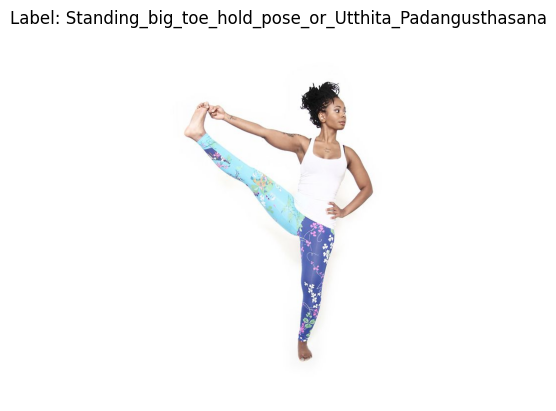

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Choose one row — e.g., index 0
sample_idx = 18000

# Get file path and label
img_path = df.iloc[sample_idx]['image_path']
pose_name = df.iloc[sample_idx]['pose_name']

# Load and display the image
img = Image.open(img_path)
plt.imshow(img)
plt.title(f"Label: {pose_name}")
plt.axis('off')
plt.show()

In [ ]:
!pip install mediapipe==0.10.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 7.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.17.1 requires protobuf<6.0.0,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
ydf 0.11.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatible.


### Transforming the images into body landmarks

In [ ]:
import os
import cv2
import mediapipe as mp
import pandas as pd
import numpy as np

# Define where the images are stored and the dataset file paths
base_image_dir = "/content/drive/MyDrive/Colab Notebooks/Yoga-82/images"  # Path to the images folder
train_file = "/content/drive/MyDrive/Colab Notebooks/Yoga-82/yoga_train.txt"  # Path to train.txt or test.txt
test_file = "/content/drive/MyDrive/Colab Notebooks/Yoga-82/yoga_test.txt"

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Function to extract landmarks from a single image
def extract_landmarks(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return None

    # Convert the image to RGB (MediaPipe uses RGB format)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Perform pose detection
    results = pose.process(image_rgb)

    # If landmarks are found, extract them
    if results.pose_landmarks:
        landmarks = []
        for landmark in results.pose_landmarks.landmark:
            landmarks.append([landmark.x, landmark.y, landmark.z])  # X, Y, Z coordinates
        return np.array(landmarks).flatten()  # Flatten to create a single vector
    else:
        return None  # Return None if no landmarks are detected

# Function to parse dataset file and extract landmarks for each image
def parse_dataset(txt_file, base_dir):
    data = []
    with open(txt_file, 'r') as f:
        for line in f:
            path, _, _, _ = line.strip().split(',')
            pose_name = path.split('/')[0]
            full_path = os.path.join(base_dir, path)

            # Extract landmarks for the image
            landmarks = extract_landmarks(full_path)
            if landmarks is not None:
                data.append((pose_name, landmarks))  # Append pose name and flattened landmarks
            else:
                print(f"Warning: Missing or unreadable image {full_path}")  # Handle missing/invalid images
    return data

# Parse train data and extract landmarks
train_data = parse_dataset(train_file, base_image_dir)
test_data = parse_dataset(test_file, base_image_dir)

# Convert to DataFrame for easier manipulation
train_df = pd.DataFrame(train_data, columns=['pose_name', 'landmarks'])
test_df = pd.DataFrame(test_data, columns=['pose_name', 'landmarks'])

# Optionally: Save the data to CSV for later use
train_df.to_csv("/content/drive/MyDrive/Colab Notebooks/Yoga-82/yoga_dataset_links/yoga_pose_landmarks_train.csv", index=False)
test_df.to_csv("/content/drive/MyDrive/Colab Notebooks/Yoga-82/yoga_dataset_links/yoga_pose_landmarks_test.csv", index=False)

print("Sample from train_df:", train_df.head())

Streaming output truncated to the last 5000 lines.
Sample from train_df:             pose_name                                          landmarks
0  Akarna_Dhanurasana  [0.42308109998703003, 0.22383755445480347, -0....
1  Akarna_Dhanurasana  [0.517612636089325, 0.3992743492126465, -0.409...
2  Akarna_Dhanurasana  [0.5636680722236633, 0.3348085880279541, -0.56...
3  Akarna_Dhanurasana  [0.6138244867324829, 0.445035457611084, -0.358...
4  Akarna_Dhanurasana  [0.5547082424163818, 0.27277570962905884, -0.4...


In [ ]:
train_df.shape

(11235, 2)

### Saving the data into CSV format

In [ ]:
train_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Yoga-82/processed_data.csv', index=False)